In [1]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from superfv import (
    OutputLoader,
    turbulent_power_specta,
    plot_timeseries,
)

In [2]:
base_path = "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/"

# Loop parameters
M_max_values = [1, 2.5, 5, 10, 25, 50]

seeds = range(1, 31)

PAD = {"rho": (0, None)}
apriori = dict(ZS=True, lazy_primitives="adaptive", PAD=PAD)
aposteriori = dict(MOOD=True, limiting_vars=("rho", "vx", "vy"), PAD=PAD)
adaptive = dict(lazy_primitives="adaptive")
lazy = dict(lazy_primitives="full")

configs = {
    "p0": dict(p=0),
    "MUSCL-Hancock": dict(p=1, MUSCL=True, MUSCL_limiter="PP2D"),
    "ZS3": dict(p=3, GL=True, **apriori),
    "ZS7": dict(p=7, GL=True, **apriori),
    "ZS3t": dict(p=3, adaptive_dt=False, **apriori),
    "ZS7t": dict(p=7, adaptive_dt=False, **apriori),
    "MM3/adaptive": dict(p=3, **aposteriori, **adaptive),
    "MM7/adaptive": dict(p=7, **aposteriori, **adaptive),
    "MM3/w1": dict(p=3, **aposteriori, **lazy),
    "MM7/w1": dict(p=7, **aposteriori, **lazy),
    "MM3b/adaptive": dict(p=3, blend=True, **aposteriori, **adaptive),
    "MM7b/adaptive": dict(p=7, blend=True, **aposteriori, **adaptive),
    "MM3b/w1": dict(p=3, blend=True, **aposteriori, **lazy),
    "MM7b/w1": dict(p=7, blend=True, **aposteriori, **lazy),
    "MM3-2/adaptive": dict(
        p=3, cascade="muscl1", max_MOOD_iters=2, **aposteriori, **adaptive
    ),
    "MM7-2/adaptive": dict(
        p=7, cascade="muscl1", max_MOOD_iters=2, **aposteriori, **adaptive
    ),
    "MM3-2/w1": dict(p=3, cascade="muscl1", max_MOOD_iters=2, **aposteriori, **lazy),
    "MM7-2/w1": dict(p=7, cascade="muscl1", max_MOOD_iters=2, **aposteriori, **lazy),
    "MM3-3/w1": dict(p=3, cascade="muscl1", max_MOOD_iters=3, **aposteriori, **lazy),
    "MM7-3/w1": dict(p=7, cascade="muscl1", max_MOOD_iters=3, **aposteriori, **lazy),
}

# read simulation outputs
data = []
for (name, config), M_max in product(configs.items(), M_max_values):
    entry = dict(config=name, M_max=M_max, failed=0)
    for seed in seeds:
        sim_path = f"{base_path}{name}/M_max_{M_max}/seed_{seed:02d}/"

        if not os.path.exists(sim_path):
            raise FileNotFoundError(sim_path)

        if os.path.exists(sim_path + "error.txt"):
            if name in ("ZS3", "ZS7"):
                print(f"{name} failed for {M_max=} and {seed=}")
                with open(sim_path + "error.txt") as f:
                    print(f"\t{f.read()}")

            entry["failed"] += 1
        elif os.path.exists(sim_path + "timings.txt"):
            continue
        else:
            raise FileNotFoundError("error.txt or timings.txt")
    data.append(entry)

df = pd.DataFrame(data)

In [3]:
df.pivot(index="M_max", columns="config", values="failed").loc[
    :,
    configs.keys(),
].sort_index(ascending=True)

config,p0,MUSCL-Hancock,ZS3,ZS7,ZS3t,ZS7t,MM3/adaptive,MM7/adaptive,MM3/w1,MM7/w1,MM3b/adaptive,MM7b/adaptive,MM3b/w1,MM7b/w1,MM3-2/adaptive,MM7-2/adaptive,MM3-2/w1,MM7-2/w1,MM3-3/w1,MM7-3/w1
M_max,,,,,,,,,,,,,,,,,,,,
1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5.0,0,0,0,0,29,30,2,4,2,5,0,0,0,0,0,0,0,0,0,0
10.0,0,0,0,0,30,30,25,19,27,20,0,1,0,1,0,0,0,0,0,0
25.0,0,0,0,0,30,30,30,30,30,30,7,17,7,15,0,0,0,0,0,0
50.0,0,0,0,0,30,30,30,30,30,30,11,22,11,16,1,0,4,0,0,0


Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MUSCL-Hancock/M_max_1/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/ZS3/M_max_1/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/ZS3t/M_max_1/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MUSCL-Hancock/M_max_5/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/ZS3/M_max_5/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MUSCL-Hancock/M_max_25/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/ZS3/M_max_25/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MUSCL-Hancock/M_max_50/seed_06"
Successfully

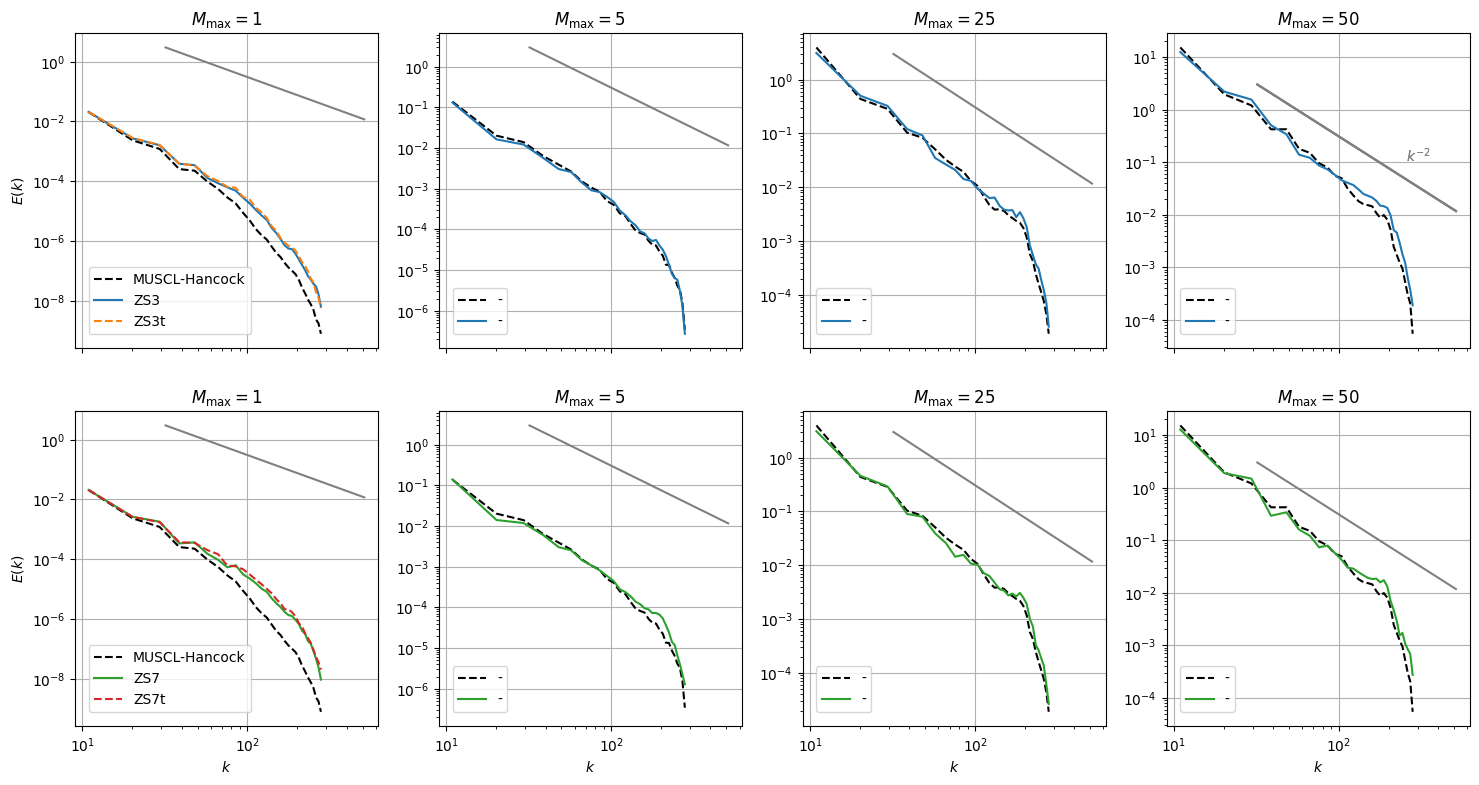

In [5]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey="col", figsize=(18, 9))

for i in range(2):
    for j in range(4):
        if i == 1:
            axs[1, j].set_xlabel(r"$k$")
        if j == 0:
            axs[i, 0].set_ylabel(r"$E(k)$")
        axs[i, j].set_xscale("log")
        axs[i, j].set_yscale("log")
        axs[i, j].grid()

M_max_values = [1, 5, 25, 50]
seed = 6
k = 3

cmap = plt.get_cmap("tab10")
styles = {
    "MUSCL-Hancock": dict(color="k", linestyle="--"),
    "ZS3": dict(color=cmap(0)),
    "ZS7": dict(color=cmap(2)),
    "ZS3t": dict(color=cmap(1), linestyle="--"),
    "ZS7t": dict(color=cmap(3), linestyle="--"),
}


def plot_power_law(ax, text=False):
    if text:
        ax.text(256, 0.1, r"$k^{-2}$", color="gray")
    ax.plot([32, 512], [3, 3 * (512 / 32) ** -2], color="gray")


for (i, j), M_max in zip([(0, 0), (0, 1), (0, 2), (0, 3)], M_max_values):
    for name in ["MUSCL-Hancock", "ZS3", "ZS3t"]:
        try:
            sim_path = f"{base_path}{name}/M_max_{M_max}/seed_{seed:02d}/"
            sim = OutputLoader(sim_path)

            w = sim.snapshots[k]["w"]
            k_centers, E_k = turbulent_power_specta(
                np, sim.variable_index_map, w, sim.mesh, nbins=30, binmode="linear"
            )

            axs[i, j].plot(
                k_centers,
                E_k,
                label="-" if j > 0 else name.replace("/w1", ""),
                **styles[name],
            )
        except Exception:
            continue

    axs[i, j].legend(bbox_to_anchor=(0, 0), loc="lower left", borderaxespad=1)

    plot_power_law(axs[i, j])
    axs[i, j].set_title(rf"$M_\max={M_max}$")
plot_power_law(axs[0, 3], text=True)

for (i, j), M_max in zip([(1, 0), (1, 1), (1, 2), (1, 3)], M_max_values):
    for name in ["MUSCL-Hancock", "ZS7", "ZS7t"]:
        try:
            sim_path = f"{base_path}{name}/M_max_{M_max}/seed_{seed:02d}/"
            sim = OutputLoader(sim_path)

            w = sim.snapshots[k]["w"]
            k_centers, E_k = turbulent_power_specta(
                np, sim.variable_index_map, w, sim.mesh, nbins=30, binmode="linear"
            )

            axs[i, j].plot(
                k_centers,
                E_k,
                label="-" if j > 0 else name.replace("/w1", ""),
                **styles[name],
            )
        except Exception:
            continue

    axs[i, j].legend(bbox_to_anchor=(0, 0), loc="lower left", borderaxespad=1)

    plot_power_law(axs[i, j])
    axs[i, j].set_title(rf"$M_\max={M_max}$")
plot_power_law(axs[0, 3], text=True)

# axs[0, 0].legend(bbox_to_anchor=(-0.4, 1), loc="upper right", borderaxespad=0.)
# axs[1, 0].legend(bbox_to_anchor=(-0.4, 1), loc="upper right", borderaxespad=0.)

In [6]:
fig.savefig("../../a-priori_spectra.png", dpi=300)

Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MUSCL-Hancock/M_max_1/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3-3/w1/M_max_1/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3-2/w1/M_max_1/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3/w1/M_max_1/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3b/w1/M_max_1/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MUSCL-Hancock/M_max_10/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3-3/w1/M_max_10/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3-2/w1/M_max_10/seed_06"
Succes

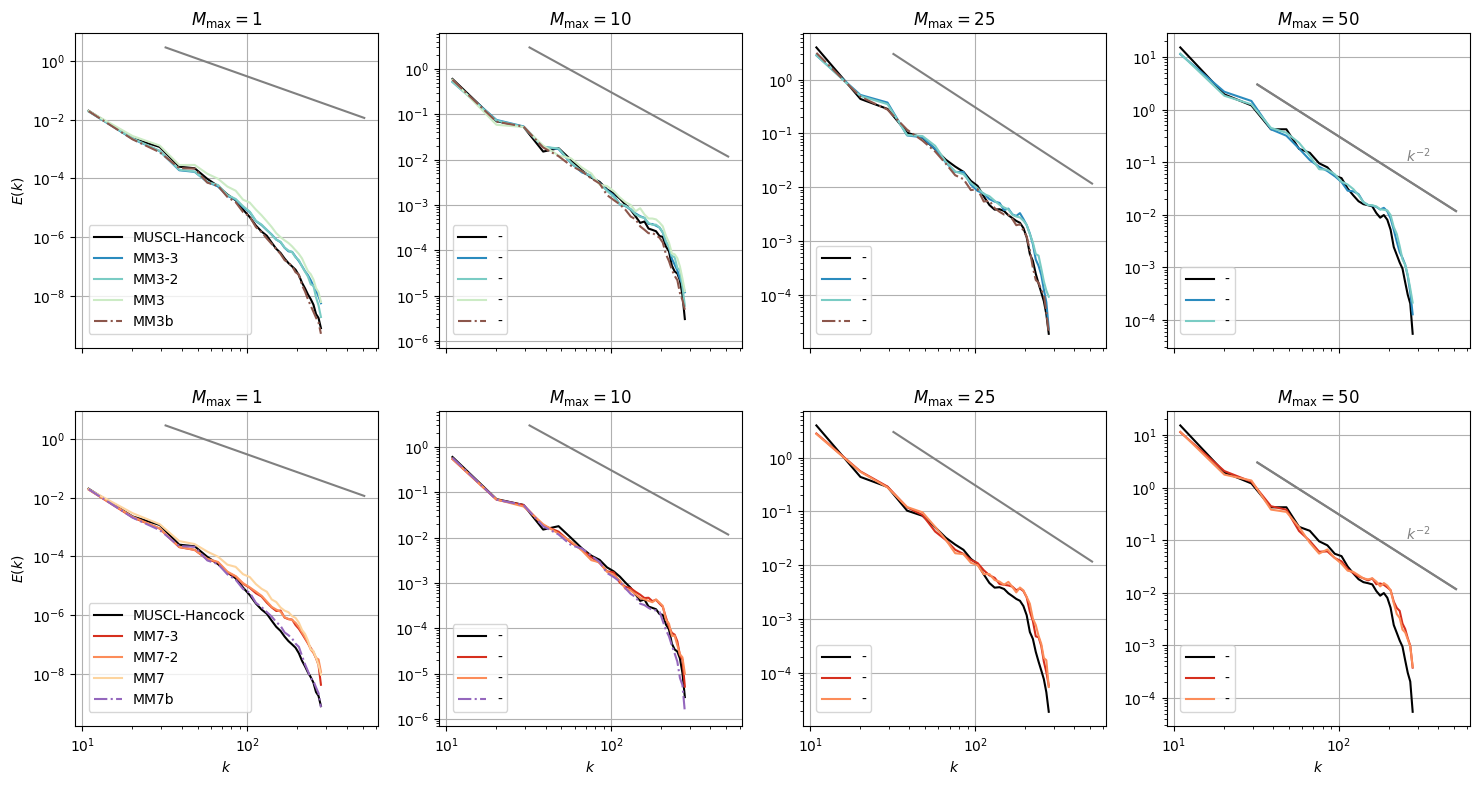

In [8]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey="col", figsize=(18, 9))

for i in range(2):
    for j in range(4):
        if i == 1:
            axs[1, j].set_xlabel(r"$k$")
        if j == 0:
            axs[i, 0].set_ylabel(r"$E(k)$")
        axs[i, j].set_xscale("log")
        axs[i, j].set_yscale("log")
        axs[i, j].grid()

M_max_values = [1, 10, 25, 50]
seed = 6
k = 3

cmap1 = plt.get_cmap("GnBu")
cmap2 = plt.get_cmap("OrRd")

styles = {
    "MUSCL-Hancock": dict(color="k"),
    "MM3/w1": dict(color=cmap1(0.25)),
    "MM7/w1": dict(color=cmap2(0.25)),
    "MM3-2/w1": dict(color=cmap1(0.5)),
    "MM7-2/w1": dict(color=cmap2(0.5)),
    "MM3-3/w1": dict(color=cmap1(0.75)),
    "MM7-3/w1": dict(color=cmap2(0.75)),
    "MM3b/w1": dict(color="tab:brown", linestyle="-."),
    "MM7b/w1": dict(color="tab:purple", linestyle="-."),
}


def plot_power_law(ax, text=False):
    if text:
        ax.text(256, 0.1, r"$k^{-2}$", color="gray")
    ax.plot([32, 512], [3, 3 * (512 / 32) ** -2], color="gray")


for (i, j), M_max in zip([(0, 0), (0, 1), (0, 2), (0, 3)], M_max_values):
    for name in ["MUSCL-Hancock", "MM3-3/w1", "MM3-2/w1", "MM3/w1", "MM3b/w1"]:
        try:
            sim_path = f"{base_path}{name}/M_max_{M_max}/seed_{seed:02d}/"
            sim = OutputLoader(sim_path)

            w = sim.snapshots[k]["w"]
            k_centers, E_k = turbulent_power_specta(
                np, sim.variable_index_map, w, sim.mesh, nbins=30, binmode="linear"
            )

            axs[i, j].plot(
                k_centers,
                E_k,
                label="-" if j > 0 else name.replace("/w1", ""),
                **styles[name],
            )
        except Exception:
            continue

    axs[i, j].legend(bbox_to_anchor=(0, 0), loc="lower left", borderaxespad=1)

    plot_power_law(axs[i, j])
    axs[i, j].set_title(rf"$M_\max={M_max}$")
plot_power_law(axs[0, 3], text=True)

for (i, j), M_max in zip([(1, 0), (1, 1), (1, 2), (1, 3)], M_max_values):
    for name in ["MUSCL-Hancock", "MM7-3/w1", "MM7-2/w1", "MM7/w1", "MM7b/w1"]:
        try:
            sim_path = f"{base_path}{name}/M_max_{M_max}/seed_{seed:02d}/"
            sim = OutputLoader(sim_path)

            w = sim.snapshots[k]["w"]
            k_centers, E_k = turbulent_power_specta(
                np, sim.variable_index_map, w, sim.mesh, nbins=30, binmode="linear"
            )
            axs[i, j].plot(
                k_centers,
                E_k,
                label="-" if j > 0 else name.replace("/w1", ""),
                **styles[name],
            )
        except Exception:
            continue

    axs[i, j].legend(bbox_to_anchor=(0, 0), loc="lower left", borderaxespad=1)

    plot_power_law(axs[i, j])
    axs[i, j].set_title(rf"$M_\max={M_max}$")
plot_power_law(axs[1, 3], text=True)

# axs[0, 0].legend(bbox_to_anchor=(-0.4, 1), loc="upper right", borderaxespad=0.)
# axs[1, 0].legend(bbox_to_anchor=(-0.4, 1), loc="upper right", borderaxespad=0.)

In [9]:
fig.savefig("../../a-posteriori_spectra.png", dpi=300)

Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3/w1/M_max_1/seed_01"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3-2/w1/M_max_1/seed_01"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3-3/w1/M_max_1/seed_01"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3/w1/M_max_5/seed_01"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3-2/w1/M_max_5/seed_01"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3-3/w1/M_max_5/seed_01"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3-2/w1/M_max_10/seed_01"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3-3/w1/M_max_10/seed_01"
Successfully read 

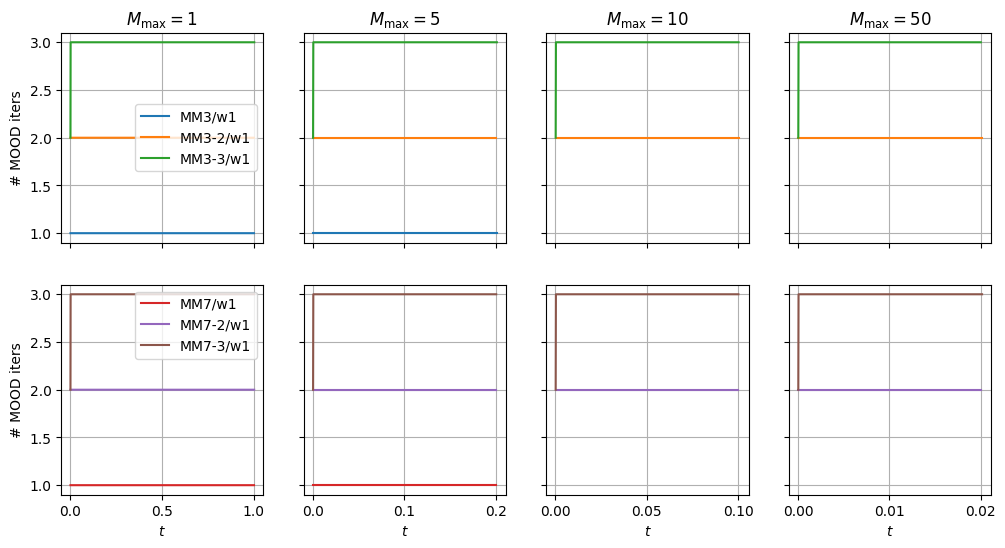

In [13]:
fig, axs = plt.subplots(2, 4, sharex="col", sharey=True, figsize=(12, 6))

for i in range(2):
    for j in range(4):
        if i == 1:
            axs[1, j].set_xlabel(r"$t$")
        if j == 0:
            axs[i, 0].set_ylabel("# MOOD iters")
        axs[i, j].grid()

M_max_values = [1, 5, 10, 50]
seed = 1
k = 3

cmap = plt.get_cmap("tab10")
styles = {
    "MUSCL-Hancock": dict(color="k", linestyle="--"),
    "MM3/w1": dict(color=cmap(0)),
    "MM7/w1": dict(color=cmap(3)),
    "MM3-2/w1": dict(color=cmap(1)),
    "MM7-2/w1": dict(color=cmap(4)),
    "MM3-3/w1": dict(color=cmap(2)),
    "MM7-3/w1": dict(color=cmap(5)),
}

for (i, j), M_max in zip([(0, 0), (0, 1), (0, 2), (0, 3)], M_max_values):
    for name in ["MM3/w1", "MM3-2/w1", "MM3-3/w1"]:
        try:
            sim_path = f"{base_path}{name}/M_max_{M_max}/seed_{seed:02d}/"
            sim = OutputLoader(sim_path)

            plot_timeseries(
                sim,
                axs[i, j],
                "nfine_MOOD_iters",
                visualization=True,
                label=name,
                **styles[name],
            )
        except Exception:
            continue
    axs[i, j].set_title(rf"$M_\max={M_max}$")

for (i, j), M_max in zip([(1, 0), (1, 1), (1, 2), (1, 3)], M_max_values):
    for name in ["MM7/w1", "MM7-2/w1", "MM7-3/w1"]:
        try:
            sim_path = f"{base_path}{name}/M_max_{M_max}/seed_{seed:02d}/"
            sim = OutputLoader(sim_path)

            plot_timeseries(
                sim,
                axs[i, j],
                "nfine_MOOD_iters",
                visualization=True,
                label=name,
                **styles[name],
            )
        except Exception:
            continue

axs[0, 0].legend()
axs[1, 0].legend()